In [2]:
import pandas as pd
import os
from collections import Counter
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
import json
import matplotlib.patches as mpatches
import scipy.stats as sc

In [3]:
setting1 = "1"
datafolder = ""
basefolder = ""
plotsfolder = 'plots'

In [4]:
def correct_distribution(distribution, occurences):
    corrected_distribution = {}
    for key in distribution.keys():
        corrected_distribution[key] = distribution[key]/occurences[key]
        if distribution[key] > occurences[key]:
            print(key)
    return corrected_distribution

In [5]:
# Compare distribution for first setting
def get_distributions (thetas, setting, k):
    K = "_k"+str(k)
    start_id=1000
    nr_samples = 500
    TPs = {}
    for theta in thetas:
        TPs[theta] = []
    all = []
    for i in range(nr_samples):
        run_id = start_id+i
        if run_id%100 == 0:
            print(run_id)
        for fold in range(5):
            filename = os.path.join(datafolder,"clustering"+setting, str(run_id)+'_'+str(fold)+K+'_predictions.csv')
            try:
                predictions = pd.read_csv(filename)
            except:
                print(filename)
            try:
                predictions['ID'] = predictions['v_b_gene']+predictions['j_b_gene']+predictions['cdr3_b_aa']
                P = predictions[predictions['labels'] == 1]
                all.extend(P['ID'])
                for theta in [0.5, 0.65, 0.75, 0.85]:
                    TP = P[P['predictions'] > theta]
                    TPs[theta].extend(TP['ID'])
                    assert len(P) >= len(TP)
            except:
                print(filename, predictions.keys())
            
    occurences = Counter(all)
    distributions = {}
    for theta in [0.5, 0.65, 0.75, 0.85]:
        distributions[theta] = correct_distribution(Counter(TPs[theta]), occurences)
    return distributions

In [7]:
# Get the distributions for all settings
# Only needs to run once
'''
thetas = [0.5, 0.65, 0.75, 0.85]
Ks = [3,5,9,11,15,19]
nested_dict_1 = {}
nested_dict_3 = {}
nested_dict_9 = {}
for k in Ks:
    print(k)
    nested_dict_1[k] = get_distributions(thetas, "1", k)
    nested_dict_3[k] = get_distributions(thetas, "3", k)
    nested_dict_9[k] = get_distributions(thetas, "9", k)
# save dicts
with open(os.path.join(basefolder,'clustering results',"nested_dict1.json"), "w") as fp:
    json.dump(nested_dict_1, fp)  

with open(os.path.join(basefolder,'clustering results',"nested_dict3.json"), "w") as fp:
    json.dump(nested_dict_3, fp)  

with open(os.path.join(basefolder,'clustering results',"nested_dict9.json"), "w") as fp:
    json.dump(nested_dict_9, fp)  
'''

'\nthetas = [0.5, 0.65, 0.75, 0.85]\nKs = [3,5,9,11,15,19]\nnested_dict_1 = {}\nnested_dict_3 = {}\nnested_dict_9 = {}\nfor k in Ks:\n    print(k)\n    nested_dict_1[k] = get_distributions(thetas, "1", k)\n    nested_dict_3[k] = get_distributions(thetas, "3", k)\n    nested_dict_9[k] = get_distributions(thetas, "9", k)\n# save dicts\nwith open(os.path.join(basefolder,\'clustering results\',"nested_dict1.json"), "w") as fp:\n    json.dump(nested_dict_1, fp)  \n\nwith open(os.path.join(basefolder,\'clustering results\',"nested_dict3.json"), "w") as fp:\n    json.dump(nested_dict_3, fp)  \n\nwith open(os.path.join(basefolder,\'clustering results\',"nested_dict9.json"), "w") as fp:\n    json.dump(nested_dict_9, fp)  \n'

In [6]:
# Run this if nested dicts are already saved
with open(os.path.join(basefolder,'clustering results',"nested_dict1.json"), "r") as fp:
    nested_dict_1 = json.load(fp)  
with open(os.path.join(basefolder,'clustering results',"nested_dict9.json"), "r") as fp:
    nested_dict_9 = json.load(fp)  
with open(os.path.join(basefolder,'clustering results',"nested_dict3.json"), "r") as fp:
    nested_dict_3 = json.load(fp)  

thetas = ['0.5', '0.65', '0.75', '0.85']
Ks = ['3','5','9','11','15','19']

In [9]:
# get one order of the tcrs
TCRs = pd.read_csv(os.path.join(basefolder,'TCRs_for_clustering/all_GCA_tcrs_clean_nodup.csv'))
TCRs['ID'] = TCRs['v_b_gene']+TCRs['j_b_gene']+TCRs['cdr3_b_aa']
TCRs = [x for x in set(TCRs['ID'])]

In [12]:
# calculate the rank overlap with nDCG score
def get_ndcg(dist1, dist2, k):
    y1 = [dist1[x] if x in dist1.keys() else 0 for x in TCRs]
    y2 = [dist2[x] if x in dist2.keys() else 0 for x in TCRs]
    return ndcg_score(np.asarray([y1]), np.asarray([y2]), k=k)


In [11]:
sns.set_theme(style="white", palette="colorblind", font_scale=1.3)

Median nDCG score:  0.9359538010925165 pm 0.16480259690647392


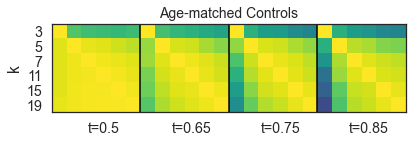

In [17]:
Ks_comparison = np.zeros((len(Ks), len(Ks)*len(thetas)))
for a, theta in enumerate(thetas):
    for i, k1 in enumerate(Ks):
        for j, k2 in enumerate(Ks):
            score = get_ndcg(nested_dict_1[k1][theta], nested_dict_1[k2][theta], 1000)
            Ks_comparison[i,j+a*6] = score
print('Median nDCG score: ', np.median(Ks_comparison),'pm', sc.iqr(Ks_comparison))
plt.imshow(Ks_comparison, vmin=0, vmax=1, cmap='viridis')
plt.yticks([0,1,2,3,4,5], [3,5,7,11,15,19])
plt.xticks([3,9,15,21], ['t=0.5','t=0.65','t=0.75','t=0.85'])
plt.axvline(x=5.5, color='black')
plt.axvline(x=17.5, color='black')
plt.axvline(x=11.5, color='black')

plt.ylabel("k")
plt.title('Age-matched Controls', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder, "comparison_1.pdf"))

Median nDCG score:  0.9128124864119617 pm 0.22436505462104583


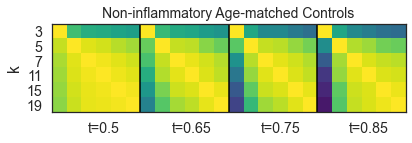

In [18]:
Ks_comparison = np.zeros((len(Ks), len(Ks)*len(thetas)))
for a, theta in enumerate(thetas):
    for i, k1 in enumerate(Ks):
        for j, k2 in enumerate(Ks):
            score = get_ndcg(nested_dict_3[k1][theta], nested_dict_3[k2][theta], 1000)
            Ks_comparison[i,j+a*6] = score
print('Median nDCG score: ', np.median(Ks_comparison),'pm', sc.iqr(Ks_comparison))
plt.imshow(Ks_comparison, vmin=0, vmax=1, cmap='viridis')
plt.yticks([0,1,2,3,4,5], [3,5,7,11,15,19])
plt.xticks([3,9,15,21], ['t=0.5','t=0.65','t=0.75','t=0.85'])
plt.axvline(x=5.5, color='black')
plt.axvline(x=17.5, color='black')
plt.axvline(x=11.5, color='black')

plt.ylabel("k")
plt.title('Non-inflammatory Age-matched Controls', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder, "comparison_3.pdf"))

In [19]:
# Compare clustering 1 and 3
Ks_comparison = np.zeros((len(Ks), len(Ks)*len(thetas)))
for a, theta in enumerate(thetas):
    for i, k1 in enumerate(Ks):
        for j, k2 in enumerate(Ks):
            score = get_ndcg(nested_dict_1[k1][theta], nested_dict_3[k2][theta], 1000)
            Ks_comparison[i,j+a*6] = score


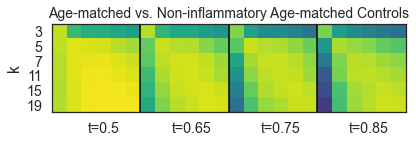

In [25]:

plt.imshow(Ks_comparison, vmin=0, vmax=1, cmap='viridis')
plt.yticks([0,1,2,3,4,5], [3,5,7,11,15,19])
plt.xticks([3,9,15,21], ['t=0.5','t=0.65','t=0.75','t=0.85'])
plt.axvline(x=5.5, color='black')
plt.axvline(x=17.5, color='black')
plt.axvline(x=11.5, color='black')

plt.ylabel("k")
plt.title('Age-matched vs. Non-inflammatory Age-matched Controls', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder, "comparison_13.pdf"))

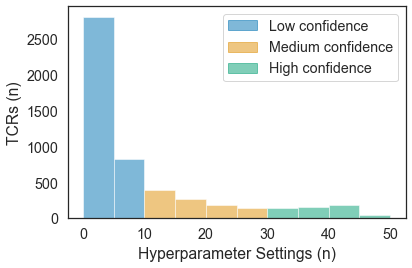

In [21]:
# Give each TCR a confidence score based on how many settings it appears among the top 1000
sns.set_theme(style="white", palette="colorblind", font_scale=1.3)

#k=11
#theta=0.5
limit=1000
in_top_1000 = []

for setting in [1,2]:
    for k in Ks:
        for theta in thetas:
            if setting == 1:
                a = np.sort(list(nested_dict_1[k][theta].values()))[::-1][limit]
                in_top_1000.extend([x for x in nested_dict_1[k][theta].keys() if nested_dict_1[k][theta][x] >= a][:limit])
                #settings += 1
            elif setting == 2:
                a = np.sort(list(nested_dict_3[k][theta].values()))[::-1][limit]
                in_top_1000.extend([x for x in nested_dict_3[k][theta].keys() if nested_dict_3[k][theta][x] >= a][:limit])
                #settings += 1
fig, ax = plt.subplots()
N, bins, patches = ax.hist(Counter(in_top_1000).values(), edgecolor='white', linewidth=1, bins=[0,5,10,15,20,25,30,35,40,45,50])

for i in range(0,2):
    patches[i].set_facecolor('#0173b2')
    patches[i].set_alpha(0.5)
for i in range(2,6):    
    patches[i].set_facecolor('C1')
    patches[i].set_alpha(0.5)
for i in range(6, len(patches)):
    patches[i].set_facecolor('C2')
    patches[i].set_alpha(0.5)
plt.xlabel('Hyperparameter Settings (n)')
plt.ylabel('TCRs (n)')
plt.tight_layout()
patch1 = mpatches.Patch(color='#0173b2',alpha=0.5, label='Low confidence')
patch2 = mpatches.Patch(color='C1',alpha=0.5, label='Medium confidence')
patch3 = mpatches.Patch(color='C2',alpha=0.5, label='High confidence')
plt.legend(handles=[patch1, patch2, patch3])
plt.savefig(os.path.join(basefolder, plotsfolder, 'histo_confidence.pdf'))

In [24]:
# Less than 10: Confidence 0
# Between 10 and 30: Confidence 1
# Over 30: Confidence 2
def assign_confidence(score):
    if score >= 30:
        confidence = 2
    elif score >= 10 and score <30:
        confidence = 1
    else:
        confidence = 0
    return confidence
InTop1000 = Counter(in_top_1000)
GCA_tcrs = pd.DataFrame()
GCA_tcrs["Id"] = list(set(InTop1000.keys()))
GCA_tcrs["InTop1000"] = GCA_tcrs["Id"].apply(lambda x: InTop1000[x])
GCA_tcrs["Confidence"] = GCA_tcrs["InTop1000"].apply(lambda x: assign_confidence(x))

print('Medium Confidence TCRs: ', len(GCA_tcrs[GCA_tcrs["Confidence"]==1]))
print('High Confidence TCRs: ', len(GCA_tcrs[GCA_tcrs["Confidence"]==2]))

high_confidence = GCA_tcrs[GCA_tcrs["Confidence"] >= 1]['Id']

all_gca_tcrs = pd.read_csv(os.path.join(basefolder,'TCRs_for_clustering/all_GCA_tcrs_clean_nodup.csv'))
all_gca_tcrs['ID'] = all_gca_tcrs['v_b_gene']+all_gca_tcrs['j_b_gene']+all_gca_tcrs['cdr3_b_aa']
high_confidence_gca_tcrs = all_gca_tcrs[all_gca_tcrs['ID'].isin(high_confidence)]

high_confidence_gca_tcrs["InTop1000"] = high_confidence_gca_tcrs["ID"].apply(lambda x: InTop1000[x])
high_confidence_gca_tcrs["Confidence"] = high_confidence_gca_tcrs["InTop1000"].apply(lambda x: assign_confidence(x))

Medium Confidence TCRs:  997
High Confidence TCRs:  528


/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
high_confidence_gca_tcrs.to_csv(os.path.join(basefolder,'resulting_TCRs', 'clustering1and3_top1000_highandmedconf.csv'))

In [ ]:
# Compare 1 to 3 and 9
Ks_comparison = np.zeros((len(Ks)*3, len(Ks)*len(thetas)))
for b, setting in enumerate([1,2,3]):
    for a, theta in enumerate(thetas):
        for i, k1 in enumerate(Ks):
            for j, k2 in enumerate(Ks):
                if setting == 1:
                    score = get_ndcg(nested_dict_1[k1][theta], nested_dict_3[k2][theta], 1000)
                elif setting == 2:
                    score = get_ndcg(nested_dict_1[k1][theta], nested_dict_9[k2][theta], 1000)
                elif setting == 3:
                    score = get_ndcg(nested_dict_3[k1][theta], nested_dict_9[k2][theta], 1000)
                Ks_comparison[i+6*b,j+a*6] = score


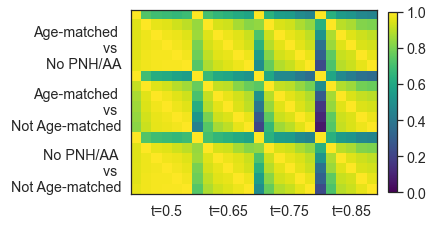

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot( 111 )
im = ax1.imshow(Ks_comparison, vmin=0, vmax=1, cmap='viridis')

ax1.set_xticks([3,9,15,21])
ax1.set_xticklabels([r't=0.5',r't=0.65',r't=0.75',r't=0.85'])
ax1.set_yticks([3,9,15])
ax1.set_yticklabels(['Age-matched \n vs \n No PNH/AA', 'Age-matched \n vs \n Not Age-matched',' No PNH/AA \n vs \n Not Age-matched'])
plt.colorbar(im,fraction=0.034, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder, "comparison_139_ndcg.pdf"), bbox_inches = "tight")